In [119]:
import numpy as np
import shapefile
import shapely
import shapely.geometry
from shapely.geometry import Polygon
from tqdm import tqdm
import pyproj
import scipy.sparse
from create_graph import create_graph
import geopandas as gpd

%load_ext autoreload    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from math import radians, cos, sin, asin, sqrt

def haversine(point1, point2):
    lon1, lat1 = point1
    lon2, lat2 = point2
    
    R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c

## Census regions

In [33]:
file = shapefile.Reader("data/SP_Setores_2021/SP_Setores_2021.shp")
new_file = shapefile.Writer("data/shapefiles/sp_census.shp")
new_file.fields = file.fields[1:]

In [34]:
for shape in tqdm(file.shapeRecords()):
    fields = dict(zip([field[0] for field in file.fields[1:]], shape.record))
    if fields["NM_MUN"] == "São Paulo":
        new_file.record(*shape.record)
        new_file.shape(shape.shape)
new_file.close()

100%|██████████| 102418/102418 [00:01<00:00, 81976.40it/s]


In [113]:
file = gpd.read_file("data/shapefiles/sp_census.shp")

selected_row = 355030866000295
selected_row = file[file["CD_SETOR"].astype(int) == selected_row]

file["distance"] = file["geometry"].apply(lambda x: x.distance(selected_row.iloc[0]["geometry"]))
file = file.sort_values(by = "distance")
file = file.reset_index(drop = True)
file = file.head(10000)

file = file.drop(columns = ["distance"])
file.to_file("data/shapefiles/sp_center_census.shp")

In [43]:
file  = shapefile.Reader("data/shapefiles/sp_census.shp")
shapes = [shapely.geometry.shape(shape) for shape in file.shapes()]
union = shapes[0]
for shape in tqdm(shapes[1:]):
    union = union.union(shape)

100%|██████████| 27591/27591 [03:08<00:00, 146.03it/s]


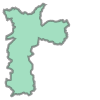

In [44]:
union

In [114]:
file  = shapefile.Reader("data/shapefiles/sp_center_census.shp")
shapes = [shapely.geometry.shape(shape) for shape in file.shapes()]
union = shapes[0]
for shape in tqdm(shapes[1:]):
    union = union.union(shape)

100%|██████████| 9999/9999 [00:16<00:00, 589.83it/s] 


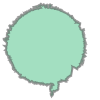

In [115]:
union

In [116]:
file = gpd.read_file("data/shapefiles/sp_census.shp")
adj_matrix = create_graph(shapefile)
np.save("data/adj_matrix/adj_matrix_sp_census.npy", adj_matrix)

100%|██████████| 27592/27592 [00:21<00:00, 1259.18it/s]


In [117]:
file = gpd.read_file("data/shapefiles/sp_center_census.shp")
adj_matrix = create_graph(shapefile)
adj_matrix = scipy.sparse.csr_matrix(adj_matrix)
scipy.sparse.save_npz("data/adj_matrix/adj_matrix_sp_center_census.npz", adj_matrix)

100%|██████████| 10000/10000 [00:07<00:00, 1340.08it/s]


## Districts

In [120]:
file = shapefile.Reader("data/LAYER_DISTRITO/DEINFO_DISTRITO.shp")
new_file = shapefile.Writer("data/shapefiles/sp_distrit.shp")
new_file.fields = file.fields[1:]

In [121]:
origin = pyproj.Proj("EPSG:29193")
target = pyproj.Proj("EPSG:4326")
def transform(x, y):
    return pyproj.transform(origin, target, x, y)

for shape in tqdm(file.shapeRecords()):
    old_shape = shapely.geometry.shape(shape.shape)
    old_coords = np.array(old_shape.exterior.coords)
    new_coords = transform(old_coords[:, 0], old_coords[:, 1])
    new_shape = shapely.geometry.Polygon(zip(new_coords[1], new_coords[0]))
    
    new_file.record(*shape.record)
    new_file.shape(new_shape)

    

  0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_64716/1076305810.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(origin, target, x, y)
100%|██████████| 96/96 [00:03<00:00, 25.36it/s]


In [122]:
new_file.close()

In [123]:
file = shapefile.Reader("data/shapefiles/sp_distrit.shp")
# create union
shapes = [shapely.geometry.shape(shape) for shape in file.shapes()]
union = shapes[0]
for shape in shapes[1:]:
    union = union.union(shape)
print("Nº polygons:", len(shapes))
union = union.buffer(0.01)
#union = union.simplify(0.01)

Nº polygons: 96


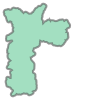

In [124]:
union

In [104]:
# save contour to geojson
with open("data/countour.geojson", "w") as f:
    f.write(shapely.to_geojson(union))
    

In [125]:
shapefile = gpd.read_file("data/shapefiles/sp_distrit.shp")
adj_matrix = create_graph(shapefile)
np.save("data/adj_matrix/adj_matrix_sp_distrit.npy", adj_matrix)

100%|██████████| 96/96 [00:00<00:00, 152.41it/s]
